### 마켓컬리 추천시스템
- 온라인 행동데이터로 유저들을 클러스터링 한 후, 온라인 행동 데이터와 상품구매목록을 변수를 Variational AutoEncoder(VAE)에 입력하여 latent space에서 벡터를 생성해낸다. 
- 새로운 고객이 방문했을 때 고객의 상품 페이지를 얼마나 자주 봤는지 얼마나 오래보았는지 등 세션정보를 활용한다. 새로운 고객의 행동패턴이 과거의 고객과 유사하다면, 과거 고객이 구매했던 고객의 상품을 추천해준다. 
- 고객들 사이에 얼마나 유사한 행동을 고객을 코사인 유사도(cosine similarity)를 활용한다. 

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

### User segmentation

In [ ]:
user_id=np.load("/content/drive/MyDrive/kurly_hackathon/data/user_save.npy")

In [ ]:
data_=pd.read_csv('/content/drive/MyDrive/kurly_hackathon/data/model_data.csv')
data_=data_.drop_duplicates(['user_id'])
data_.head()

,user_id,purchae_price_sum,view_cnt,cart_cnt,purchase_cnt,conversion_rate,product_cnt,session_cnt,Recency,Frequency,Monetary
0,513539969,27130.51,525,59,71,0.108396,52,6,5.713299,1,27130.51
1,515954723,2894.53,948,81,51,0.047222,24,1,13.399873,1,2894.53
2,555160976,28547.72,1145,45,41,0.033306,37,1,0.245544,1,28547.72
3,533774988,55486.34,236,36,66,0.195266,66,1,16.361748,1,55486.34
4,546956050,13661.55,178,68,59,0.193442,53,1,11.822766,1,13661.55


In [ ]:
data_=data_.loc[data_["user_id"].isin(user_id)]

In [ ]:
data_.shape

(1405, 11)

In [ ]:
user_lst=data_["user_id"].tolist()

np.random.seed(7)
train_user=np.random.choice(user_lst, size=int(len(user_lst)*0.8), replace=False) # train user_id
test_user=list(set(user_lst)-set(train_user)) # test user_id


In [ ]:
print(len(train_user),len(test_user))

1124 281


In [ ]:
test_user

[512765442,
 551945219,
 519642115,
 513267717,
 560974854,
 547184130,
 521798666,
 541055498,
 555916298,
 512703499,
 512393742,
 513536526,
 541745169,
 513848850,
 522219027,
 527759897,
 557486618,
 516629021,
 512394269,
 543351839,
 533029919,
 564764705,
 512381472,
 560001569,
 529336356,
 542856221,
 548539430,
 556660767,
 538882091,
 524448300,
 549680685,
 564604974,
 512531501,
 513769006,
 520470579,
 533863988,
 515770933,
 557257269,
 560440375,
 525070902,
 553197626,
 514565691,
 517425212,
 520867389,
 558020156,
 513924669,
 513979463,
 541318727,
 519145545,
 517980238,
 550529104,
 518805584,
 519274578,
 562463314,
 544890451,
 514079317,
 512432726,
 512514648,
 514692698,
 515544667,
 546991708,
 557907552,
 545248353,
 520987237,
 514144359,
 563400817,
 522138738,
 552056437,
 521474172,
 543567485,
 539132542,
 560456319,
 534301314,
 548740739,
 515211909,
 514087045,
 545853575,
 553318534,
 533691934,
 547502738,
 512916627,
 546058391,
 555008152,
 554

In [ ]:
online_features=['purchae_price_sum', 'view_cnt', 'cart_cnt', 'purchase_cnt', 'conversion_rate', 'product_cnt', 'Recency', 'Frequency', 'Monetary']
train_data=data_.loc[data_["user_id"].isin(train_user)] # train dataset
df=train_data[['purchae_price_sum', 'view_cnt', 'cart_cnt', 'purchase_cnt', 'conversion_rate', 'product_cnt', 'Recency', 'Frequency', 'Monetary']] # 학습 시키기 위해서 user id 제외하고 남기기

test_df=data_.loc[data_["user_id"].isin(test_user)] # test dataset


In [ ]:
print(len(df),len(test_df))

1124 281


In [ ]:
SS=StandardScaler().fit(df) # 온라인 행동패턴 표준화

x=SS.transform(df) # 온라인 행동패턴 표준화
test_x=SS.transform(test_df[online_features])

### 온라인 행동패턴을 기반으로 클러스터링 진행

In [ ]:
columns_lst=['cart_cnt', 'purchase_cnt','conversion_rate', 'session_cnt', 'Recency', 'Frequency', 'Monetary',"product_variable"]

In [ ]:
from tqdm import tqdm
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_sample_lst,silhouette_score_lst=[],[]

for k in tqdm(range(2, 15)):
    kmeans=KMeans(n_clusters=k, random_state=100,init="random")
    kmeans.fit(x)

    kmeans_label=kmeans.labels_
    silhouette_sample_lst.append(silhouette_samples(x, kmeans_label))
    silhouette_score_lst.append(silhouette_score(x, kmeans_label))


100%|██████████| 13/13 [00:03<00:00,  4.13it/s]


In [ ]:
k=7
kmeans=KMeans(n_clusters=k, random_state=100,init="random")
kmeans.fit(x)

kmeans_label=kmeans.labels_
silhouette_=pd.DataFrame(silhouette_sample_lst[k-2],columns=["ss"])
silhouette_["label"]=kmeans_label

print(silhouette_score_lst[k-2])
silhouette_.groupby("label").aggregate([np.mean, len]) # 2, 3,4가 클러스터링 잘 됨

0.21431051740129572


ss     
           mean  len
label               
0      0.281667  298
1      0.128383  142
2      0.209545  351
3      0.225347   30
4      0.203456  148
5      0.340991    6
6      0.176174  149

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

# 2차원으로 차원 축소
n_components = 2

# t-sne 모델 생성
model = TSNE(n_components=n_components)
tsne_np=model.fit_transform(x)

tsne_df=pd.DataFrame(tsne_np, columns=["component0", "component1"])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
k=7
kmeans=KMeans(n_clusters=k, random_state=100,init="random")
kmeans.fit(x)
tsne_df["kmeans_label"]=kmeans_label


In [ ]:
tsne_df["user_id"]=train_user

In [ ]:
tsne_df.head()

,component0,component1,kmeans_label,user_id
0,-23.969860,34.921703,5,512877624
1,-27.887550,-27.900116,1,522210904
2,-24.842239,-29.851259,1,540334105
3,-29.968092,-8.837125,1,526004290
4,-25.750898,-19.651613,1,562432917


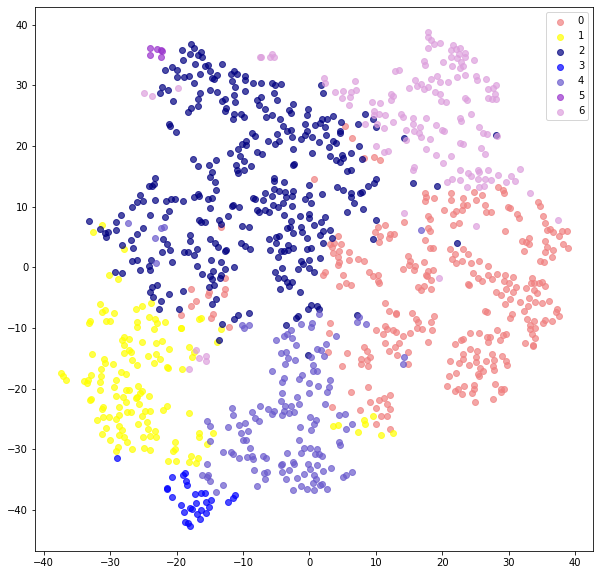

In [ ]:
import matplotlib.pyplot as plt
color = ["lightcoral","yellow","navy","blue","slateblue","darkorchid","plum","magenta","hotpink",
         "aquamarine","orange","wheat","gold","darkolivegreen","darkseagreen",
         "teal","cyan","deepskyblue","steelblue","palereen","peru"]

plt.figure(figsize=(10,10))
for label in range(7):
    temp_df=tsne_df.loc[tsne_df["kmeans_label"]==label]
    plt.scatter(temp_df["component0"],temp_df["component1"],c=color[label], alpha=0.7, cmap="Spectral", label=label)

plt.legend()
plt.show()

In [ ]:
cluster_dict={"%d"%i:tsne_df.loc[tsne_df["kmeans_label"]==i]["user_id"].tolist() for i in range(7)}

In [ ]:
new_X=test_x  #(새로운 유저수, 9)의 shape
y_kmeans=kmeans.fit_predict(test_x)
# 새로운 유저가 속한 군집
print(y_kmeans)

[4 6 6 6 6 4 4 4 4 4 4 4 6 1 1 1 1 2 1 1 4 1 6 6 6 4 4 6 6 6 6 0 5 0 0 5 0
 5 5 5 0 3 1 5 0 5 3 0 5 5 5 2 0 3 3 5 5 5 0 0 3 5 0 2 3 3 3 5 3 3 3 6 3 5
 0 5 3 5 5 5 5 2 3 0 0 1 3 0 0 0 5 0 0 3 1 3 3 1 5 0 1 1 3 3 5 5 5 1 2 0 5
 0 5 2 3 3 3 0 3 5 0 3 5 3 5 3 2 2 3 3 0 1 1 5 3 5 5 5 2 3 0 3 3 5 3 1 0 2
 6 0 3 0 3 3 3 5 5 3 3 5 1 1 0 1 1 3 3 5 0 5 3 2 3 3 3 0 1 0 3 0 0 2 2 3 6
 2 3 3 5 1 3 2 0 2 2 0 4 6 1 0 3 5 0 0 3 2 3 2 3 2 2 3 3 3 1 2 1 5 3 3 3 1
 3 3 3 5 3 2 3 3 4 4 1 3 3 2 3 6 1 3 2 2 6 1 1 0 3 6 4 1 3 1 2 6 6 6 1 2 2
 1 2 2 1 4 6 6 6 6 1 6 4 1 1 1 6 6 6 6 0 6 4]


In [ ]:
l=pd.DataFrame(y_kmeans, columns=["test_label"])
l["user_id"]=test_user

In [ ]:
test_cluster_dict={"%d"%i:l.loc[l["test_label"]==i]["user_id"].tolist() for i in range(7)}

In [ ]:
print([("%d번:"%i,len(cluster_dict["%d"%i])) for i in range(7)])

[('0번:', 298), ('1번:', 142), ('2번:', 351), ('3번:', 30), ('4번:', 148), ('5번:', 6), ('6번:', 149)]


### SGNS을 활용하여 임베딩벡터 만들기

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
vector_dim=1
path="/content/drive/MyDrive/kurly_hackathon/data/arr_save.npy" # 구매목록 데이터
arr=np.load(path)

In [ ]:
arr.shape

(3000, 39)

In [ ]:
arr_df=pd.DataFrame(arr, columns=list(range(arr.shape[1])))
arr_df["user_id"]=user_id

In [ ]:
arr_df=arr_df[["user_id"]+list(range(arr.shape[1]))]

In [ ]:
uid=train_user # user_id 구매목록과 온라인 행동데이터가 함께 있는 user_id 중에서 train_user

In [ ]:
product_df=arr_df.loc[arr_df["user_id"].isin(uid)]# train_user만 모으기

In [ ]:
test_pdf=arr_df.loc[arr_df["user_id"].isin(test_user)]# test_user만 모으기

In [ ]:
print(product_df.shape,  test_pdf.shape)

(1124, 40) (281, 40)


In [ ]:
product_lst=product_df.loc[:,list(range(arr.shape[1]))].values  # numpy 배열만 뽑아내기

In [ ]:
pplst=[] # 문자열 형태로 바꿔서 이중리스트로 구매목록 저장

for i in range(len(product_lst)):
    try:
        idx=list(product_lst[i]).index(0)
        tt=list(product_lst[i][:idx])
        tt=list(map(int,tt))
        tt=list(map(str,tt))
        pplst.append(tt)
    except:
        tt=list(product_lst[i][:idx])
        tt=list(map(int,tt))
        tt=list(map(str,tt))
        pplst.append(tt)
    

In [ ]:
tokenizer = Tokenizer(lower=False, oov_token="<oov>") # tokenizer
tokenizer.fit_on_texts(pplst)

word2idx = tokenizer.word_index
idx2word = {value : key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(pplst)

In [ ]:
product_size=len(word2idx)

In [ ]:
from tensorflow.keras.preprocessing.sequence import skipgrams
# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size=product_size, window_size=10) for sample in encoded]

In [ ]:
# window10내에서 중심 상품과 주변 상품 관계를 가지면 1, 아니면 0

skip_grams[0][1][:5] #[첫번째 샘플의][skipgrams로 형성된 라벨]

[0, 0, 0, 0, 0]

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [ ]:
embedding_dim = 1
product_size=len(word2idx)

# 중심 상품를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(product_size, embedding_dim)(w_inputs)

# 주변 상품를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(product_size, embedding_dim)(c_inputs)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 1)         3558        ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 1)         3558        ['input_2[0][0]']                
                                                                                              

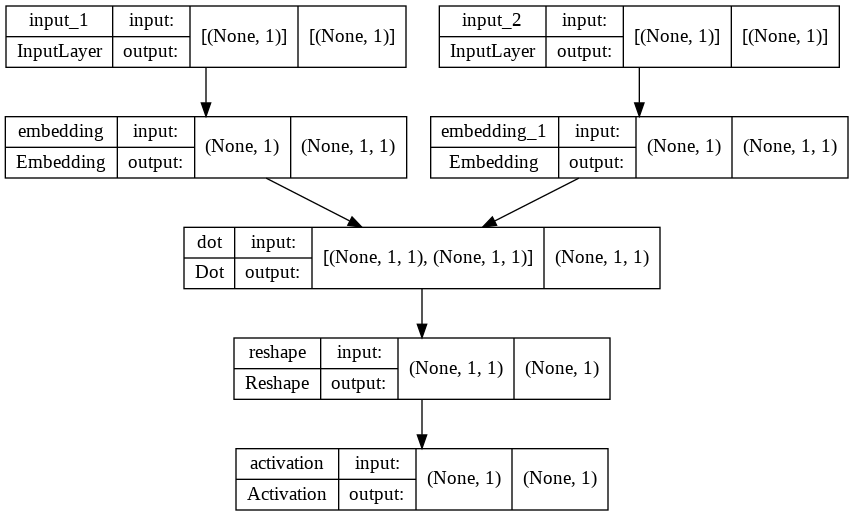

In [ ]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [ ]:
loss_=[]
for epoch in range(1, 20):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  
    loss_.append({'Epoch':epoch, 'Loss':loss})
    print('Epoch :',epoch, 'Loss :',loss)

Epoch : 1 Loss : 776.4794331789017
Epoch : 2 Loss : 753.2604084610939
Epoch : 3 Loss : 714.9813295602798
Epoch : 4 Loss : 675.0008089542389
Epoch : 5 Loss : 639.0531645566225
Epoch : 6 Loss : 608.8105797767639
Epoch : 7 Loss : 584.2331501692533
Epoch : 8 Loss : 564.6280726715922
Epoch : 9 Loss : 549.097510881722
Epoch : 10 Loss : 536.751524977386
Epoch : 11 Loss : 526.8265899419785
Epoch : 12 Loss : 518.7220785841346
Epoch : 13 Loss : 511.990467377007
Epoch : 14 Loss : 506.306131914258
Epoch : 15 Loss : 501.4366344437003
Epoch : 16 Loss : 497.21556460112333
Epoch : 17 Loss : 493.52089462429285
Epoch : 18 Loss : 490.26002828776836
Epoch : 19 Loss : 487.3614853769541


In [ ]:
len(tokenizer.word_index.items())

3558

In [ ]:
vectors = model.get_weights()[0] # embedding vector
words=[word for word,_ in tokenizer.word_index.items()]
idx=[i for _,i in tokenizer.word_index.items()]

#### 임베딩 벡터 테이블
- 위에서 학습한 임베딩 벡터를 변수에 포함시킨다.

In [ ]:
embedding_vec=pd.DataFrame(words, columns=["word"])
embedding_vec["idx"]=idx
embedding_vec["vector"]=vectors

embedding_vec.tail()

,word,idx,vector
3553,3700800,3554,-0.236737
3554,3700801,3555,-0.060784
3555,3200538,3556,-0.134757
3556,10900153,3557,0.253856
3557,11100283,3558,0.060985


In [ ]:
embedding_vec.head()

,word,idx,vector
0,<oov>,1,-0.006207
1,1004856,2,-0.003613
2,1004767,3,-2.037908
3,1005115,4,-2.032199
4,4804056,5,-2.034074


In [ ]:
embedding_vec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3558 entries, 0 to 3557
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   word    3558 non-null   object 
 1   idx     3558 non-null   int64  
 2   vector  3558 non-null   float32
dtypes: float32(1), int64(1), object(1)
memory usage: 69.6+ KB


In [ ]:
embedding_vec.loc[embedding_vec.shape[0]]=["<pad>",embedding_vec.shape[0]+1,0]

### padding & embedding vector로 변환

- train dataset에 embedding 적용

In [ ]:
embd_lst_tr=np.zeros((len(product_lst),39)) # train_dataset padding
for i in range(len(pplst)):
    for j in range(len(pplst[i])):
        embd_lst_tr[i][j]=embedding_vec.loc[embedding_vec["word"]==pplst[i][j],"vector"] # 상품명을 embedding vector로 바꿈

In [ ]:
embd_lst_tr[0] # product_id가 embedding vector로 바뀐 것 확인

array([-0.65099645, -0.65099645, -0.65099645, -0.65099645, -0.65099645,
       -0.65099645,  0.22246383,  0.3675015 ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [ ]:
test_pdf.head()

,user_id,0,1,2,3,4,5,6,7,8,...,29,30,31,32,33,34,35,36,37,38
8,556652468,1004767.0,1004833.0,1307140.0,2701419.0,13200539.0,13200539.0,13200539.0,1004767.0,1005238.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,514565691,1005205.0,1005205.0,1005205.0,3700777.0,1005238.0,1005100.0,1004838.0,1005238.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,554837656,1004767.0,1004856.0,1004767.0,1004767.0,1004767.0,28716967.0,1004767.0,51900015.0,28712682.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,555916298,1005031.0,1005064.0,3700039.0,1005115.0,1004249.0,1005140.0,1004249.0,1004856.0,1005062.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54,556761274,4804056.0,12708221.0,12708109.0,4804056.0,4804055.0,16700605.0,15200915.0,15200184.0,3800161.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### test dataset에 embedding 적용

In [ ]:
arr_temp=test_pdf[test_pdf.columns[1:]].values

embd_lst_test=np.zeros((len(arr_temp),39)) # train_dataset padding
for i in range(len(arr_temp)):
    for j in range(len(arr_temp[i])):
        try:
            embd_lst_test[i][j]=embedding_vec.loc[embedding_vec["word"]==str(int(arr_temp[i][j])),"vector"] # 상품명을 embedding vector로 바꿈
        except:
            embd_lst_test[i][j]=embedding_vec.loc[embedding_vec["word"]=="<oov>","vector"] # 만일 train에 없는 product_id vector라면 <oov>에 해당하는 임베딩 벡터가 들어감

embd_lst_tr와 embd_lst_test를 함께 합쳐서 PCA진행

In [ ]:
new_embed=np.concatenate([embd_lst_tr,embd_lst_test])

In [ ]:
train_=len(embd_lst_tr)

### PCA- 차원 축소

In [ ]:
from sklearn.decomposition import PCA

embd_X=StandardScaler().fit_transform(new_embed) # embedding vector로 변환한 구매목록 리스트를 표준화 시켜서 차원축소한다.

In [ ]:
pca=PCA(n_components=1) # 1차원으로 decompose한다.
principal=pca.fit_transform(embd_X)

pdf=pd.DataFrame(principal)
pdf["user_id"]=train_user.tolist()+test_user

In [ ]:
pdf.head()

,0,user_id
0,-2.373081,512877624
1,-1.123862,522210904
2,-0.073427,540334105
3,1.334199,526004290
4,-1.952718,562432917


In [ ]:
online=pd.read_csv("/content/drive/MyDrive/kurly_hackathon/data/model_data.csv")

In [ ]:
online.head()

,user_id,purchae_price_sum,view_cnt,cart_cnt,purchase_cnt,conversion_rate,product_cnt,session_cnt,Recency,Frequency,Monetary
0,513539969,27130.51,525,59,71,0.108396,52,6,5.713299,1,27130.51
1,515954723,2894.53,948,81,51,0.047222,24,1,13.399873,1,2894.53
2,555160976,28547.72,1145,45,41,0.033306,37,1,0.245544,1,28547.72
3,533774988,55486.34,236,36,66,0.195266,66,1,16.361748,1,55486.34
4,546956050,13661.55,178,68,59,0.193442,53,1,11.822766,1,13661.55


In [ ]:
df_lst=pd.merge(online,pdf,on="user_id",how="right") # 온라인 행동 데이터와 임베딩 벡터 붙이기

In [ ]:
df_lst.columns=df_lst.columns[:-1].tolist()+["product_variable"]

In [ ]:
df_lst.head()

,user_id,purchae_price_sum,view_cnt,cart_cnt,purchase_cnt,conversion_rate,product_cnt,session_cnt,Recency,Frequency,Monetary,product_variable
0,512877624,1721.80,43,8,10,0.163934,9,1,11.700938,1,1721.80,-2.373081
1,522210904,899.79,185,7,8,0.040000,3,1,1.874664,1,899.79,-1.123862
2,540334105,6361.08,157,59,34,0.136000,34,1,0.519109,1,6361.08,-0.073427
3,526004290,3243.48,40,8,16,0.250000,13,1,1.638021,1,3243.48,1.334199
4,562432917,18832.82,96,19,24,0.172661,22,1,13.713229,1,18832.82,-1.952718


In [ ]:
col_name=df_lst.columns[1:]

In [ ]:
# 온라인 행동데이터+임베딩벡터
df_lst.to_csv("/content/drive/MyDrive/kurly_hackathon/data/data_ver2.csv",index=False)

In [ ]:
# train에 해당하는 유저와 테스트에 해당하는 유저 나누기
X_train=df_lst.loc[df_lst["user_id"].isin(train_user)]
X_test=df_lst.loc[df_lst["user_id"].isin(test_user)]

In [ ]:
### VAE돌릴 데이터만 표준화시킨다.
columns_lst=['cart_cnt', 'purchase_cnt','conversion_rate', 'session_cnt', 'Recency', 'Frequency', 'Monetary',"product_variable"]

st=StandardScaler().fit(X_train[columns_lst])
X_Train=st.transform(X_train[columns_lst]) # 표준화
X_Test=st.transform(X_test[columns_lst]) # 표준화

In [ ]:
df_lst.loc[df_lst["user_id"].isin(test_user)]

,user_id,purchae_price_sum,view_cnt,cart_cnt,purchase_cnt,conversion_rate,product_cnt,session_cnt,Recency,Frequency,Monetary,product_variable
1124,512765442,6856.87,172,10,9,0.047120,9,1,12.568854,1,6856.87,-1.619308
1125,551945219,1028.89,137,17,25,0.139664,5,1,29.517326,1,1028.89,-1.478958
1126,519642115,4009.87,35,19,15,0.217391,15,1,1.753368,1,4009.87,2.689350
1127,513267717,4626.32,21,8,10,0.256410,10,1,2.362002,1,4626.32,1.019736
1128,560974854,3564.53,60,15,11,0.127906,11,1,10.620243,1,3564.53,-2.092049
...,...,...,...,...,...,...,...,...,...,...,...,...
1400,516512242,2807.38,71,16,11,0.112244,10,1,13.738194,1,2807.38,5.597839
1401,548134390,4813.32,60,16,13,0.146067,11,1,0.508819,1,4813.32,-1.834339
1402,534709241,1594.31,121,15,8,0.055555,5,1,13.453773,1,1594.31,2.556003
1403,513064955,4305.17,73,14,15,0.147058,12,1,4.295671,1,4305.17,0.466393


In [ ]:
X_TRAIN=pd.DataFrame(X_Train, columns=columns_lst)
X_TEST=pd.DataFrame(X_Test, columns=columns_lst)

X_TRAIN["user_id"]=X_train["user_id"]
X_TEST["user_id"]=test_user

X_TEST.head()

,cart_cnt,purchase_cnt,conversion_rate,session_cnt,Recency,Frequency,Monetary,product_variable,user_id
0,-0.634399,-0.779360,-1.091500,-0.205424,0.052149,0.0,0.436895,-0.460282,512765442
1,-0.152924,1.431716,0.352491,-0.205424,1.686739,0.0,-0.742697,-0.420095,551945219
2,-0.015360,0.049793,1.565288,-0.205424,-0.990947,0.0,-0.139342,0.773432,519642115
3,-0.771963,-0.641168,2.174112,-0.205424,-0.932248,0.0,-0.014571,0.295365,513267717
4,-0.290488,-0.502976,0.169027,-0.205424,-0.135784,0.0,-0.229479,-0.595643,560974854


In [ ]:
X_TRAIN.to_csv("/content/drive/MyDrive/kurly_hackathon/data/train.csv",index=False)
X_TEST.to_csv("/content/drive/MyDrive/kurly_hackathon/data/test.csv",index=False)

### VAE(전체 데이터 넣고 VAE)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
X_TRAIN=pd.read_csv("/content/drive/MyDrive/kurly_hackathon/data/train.csv")
X_TEST=pd.read_csv("/content/drive/MyDrive/kurly_hackathon/data/test.csv")

In [ ]:
batch_size = 8
lr = 0.001
epoch = 10
hidden_size = 7

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
columns_lst=['cart_cnt', 'purchase_cnt','conversion_rate', 'session_cnt', 'Recency', 'Frequency', 'Monetary',"product_variable"]
X_train=X_TRAIN[columns_lst].values
X_test=X_TEST[columns_lst].values

In [ ]:
from torch.utils.data import Dataset, DataLoader
class DataBuilder(Dataset):
    def __init__(self, X_train, X_test, standardizer, train=True):
        self.X_train, self.X_test, self.standardizer =  X_train, X_test, standardizer
        if train:
            self.x = torch.from_numpy(self.X_train)
            self.len=self.x.shape[0]
        else:
            self.x = torch.from_numpy(self.X_test)
            self.len=self.x.shape[0]
        #del self.X_train
        #del self.X_test 
    def __getitem__(self,index):      
        return self.x[index]
    def __len__(self):
        return self.len

### 데이터셋 준비

In [ ]:
X_train=X_train[:1120]
X_test=X_test[:280]

traindata_set=DataBuilder(X_train,X_test,st, train=True)
testdata_set=DataBuilder(X_train,X_test,st, train=False)

trainloader=DataLoader(dataset=traindata_set,batch_size=32)
testloader=DataLoader(dataset=testdata_set,batch_size=32)

In [ ]:
X_test.shape

(280, 8)

In [ ]:
type(trainloader.dataset.x), type(testloader.dataset.x)

(torch.Tensor, torch.Tensor)

In [ ]:
trainloader.dataset.x.shape, testloader.dataset.x.shape

(torch.Size([1120, 8]), torch.Size([280, 8]))

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self,D_in,H=50,H2=12,latent_dim=3):
        
        #Encoder
        super(Autoencoder,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2=nn.Linear(H,H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3=nn.Linear(H2,H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)
        
        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

        # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)
        
        # Decoder
        self.linear4=nn.Linear(H2,H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5=nn.Linear(H2,H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6=nn.Linear(H,D_in)
        self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)
        
        self.relu = nn.ReLU()
        self.double()
        
    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))


        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
    
    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

In [ ]:
D_in = trainloader.dataset.x.shape[1]
H = 50
H2 = 12
model = Autoencoder(D_in, H, H2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
loss_mse = customLoss()

### Train Model

In [ ]:
epochs = 20
log_interval = 5
val_losses = []
train_losses = []
test_losses = []

In [ ]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if epoch % 200 == 0:        
        print('====> Epoch: {} Average training loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))

In [ ]:
def test(epoch):
    with torch.no_grad():
        test_loss = 0
        for batch_idx, data in enumerate(testloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_mse(recon_batch, data, mu, logvar)
            test_loss += loss.item()
            if epoch % 200 == 0:        
                print('====> Epoch: {} Average test loss: {:.4f}'.format(
                    epoch, test_loss / len(testloader.dataset)))
            test_losses.append(test_loss / len(testloader.dataset))

In [ ]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

### 추론(inference)를 위해 모델 저장하기 

In [ ]:
PATH="/content/drive/MyDrive/kurly_hackathon/model"

# PATH 위치에 저장하기
torch.save(model.state_dict(), PATH+"/VAE_toal.pt")

"""
# 모델 불러오기
model = torch.load(PATH+"/VAE_toal.pt") # input으로 저장된 디렉토리만 지정하면 완료
"""

'\n# 모델 불러오기\nmodel = torch.load(PATH+"/VAE_toal.pt") # input으로 저장된 디렉토리만 지정하면 완료\n'

#### 학습이 잘 되어있는지 확인하자.

In [ ]:
scaler = trainloader.dataset.standardizer

with torch.no_grad():
    for batch_idx, data in enumerate(testloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)


In [ ]:
recon_row = scaler.inverse_transform(recon_batch.cpu().numpy())
real_row = scaler.inverse_transform(testloader.dataset.x.cpu().numpy())

In [ ]:
df = pd.DataFrame(np.stack((recon_row[0], real_row[0])), columns = columns_lst)
df # 근사하게 복원되는 것을 보아서 괜찮은 편이다.

,cart_cnt,purchase_cnt,conversion_rate,session_cnt,Recency,Frequency,Monetary,product_variable
0,15.442455,11.946623,0.092859,1.092694,16.277014,1.145937,3098.623712,0.752278
1,10.000000,9.000000,0.047120,1.000000,12.568854,1.000000,6856.870000,-1.619308


In [ ]:
print([("%d번:"%i,len(cluster_dict["%d"%i])) for i in range(7)])

[('0번:', 298), ('1번:', 142), ('2번:', 351), ('3번:', 30), ('4번:', 148), ('5번:', 6), ('6번:', 149)]


In [ ]:
total_cluster_user=[test_cluster_dict["%d"%i] for i in [1,3,5,6]]

In [ ]:
total_cluster=total_cluster_user[0]+total_cluster_user[1]+total_cluster_user[2]

In [ ]:
G_lst=[]
with torch.no_grad():
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        G=scaler.inverse_transform(recon_batch.cpu().numpy())

        G_lst.extend(list(G))

In [ ]:
Guser_total=pd.DataFrame(np.stack(G_lst), index=train_user[:1120], columns=columns_lst)

In [ ]:
Guser_total.head() # 훈련셋 데이터로 생성된 벡터

,cart_cnt,purchase_cnt,conversion_rate,session_cnt,Recency,Frequency,Monetary,product_variable
512877624,12.858452,10.870073,0.089878,1.015773,15.591837,1.044305,2575.749407,1.090592
522210904,12.858452,10.870073,0.089878,1.015773,15.591837,1.044305,2575.749407,1.090592
540334105,35.145469,24.167864,0.138262,0.715458,5.974163,1.727072,12133.130985,-2.882372
526004290,22.894190,15.573078,0.103529,2.579396,16.059695,1.414125,2983.528565,-1.202227
562432917,37.425827,20.393299,0.144586,1.330421,6.451871,0.579023,8190.249630,-1.510899


#### 작은 군집에 있던 1,3,4,5,6의 테스터

In [ ]:
def similar_customer(df_lst,user,total_cluster, Guser_total):
    total_dict={}
    for tester in total_cluster:
        total_lst=[]
        for i, row in Guser_total.iterrows():
            data=df_lst[df_lst["user_id"].isin([tester])][columns_lst].values
            cosine_sim = cosine_similarity(data, row.values.reshape(-1,8))
            total_lst.append(cosine_sim[0][0])
        total_dict[tester]=total_lst

    total_cdf=pd.DataFrame(total_dict, index=user)

    similar_20={}
    for tester in total_cluster:
        similar_20[tester]=total_cdf[tester].sort_values(ascending=False).index[:20].tolist() # tester와 유사한 20명
    return pd.DataFrame(similar_20)

In [ ]:
# 컬럼에 테스터의 아이디가 있고, 칸에는 테스터와 가장 가까운 훈련 데이터셋의 사람들이 있음.
similar_totalG=similar_customer(df_lst, train_user[:1120],total_cluster, Guser_total)

In [ ]:
similar_totalG.to_csv("/content/drive/MyDrive/kurly_hackathon/data1/most_similar_totalG.csv")

테스터의 아이디를 입력하면 추천 상품이 나옴

In [ ]:
def recommend_list(tester_id,product_df, similar_totalG):
    tr_product=product_df.set_index("user_id").T # 컬럼에 train의 사람들이 있음.
    sp=similar_totalG[tester_id] # similar_totalG
    p_lst=[]
    for i in sp:
        p_lst.extend(tr_product[i].tolist())
    recommend_lst=pd.Series(p_lst).value_counts().reset_index()
    recommend_product=recommend_lst["index"][:20].tolist()
    pred=list(map(int,recommend_product))
    return pred

In [ ]:
from sklearn.metrics import ndcg_score

# VAE total로 예측한 사람들의 추천 목록
def nDCG(tester): # tester의 user_id
    recommend_preds={tester:recommend_list(tester, product_df, similar_totalG) for tester in similar_totalG.columns}
    tester_real=test_pdf.set_index("user_id").T
    real_p=tester_real[tester]
    return ndcg_score([list(real_p[:20])], [recommend_preds[tester]])

In [ ]:
recommend_preds={tester:recommend_list(tester, product_df, similar_totalG) for tester in similar_totalG.columns}

tester=similar_totalG.columns[0]
tester_real=test_pdf.set_index("user_id").T
real_p=tester_real[tester]

print(tester)
print("추천상품:",recommend_preds[tester])
print("실제구매 상품:", list(real_p))

513848850
추천상품: [0, 1004767, 1004856, 4804701, 14100002, 1002524, 5000084, 1004833, 1801690, 1701285, 1004870, 1004903, 1004565, 2200885, 1002629, 1004904, 1005236, 26205283, 1003312, 1005015]
실제구매 상품: [1800944.0, 3800548.0, 3800751.0, 3800548.0, 3800751.0, 3800751.0, 3800751.0, 3800751.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
nDCG(tester)

0.704811983873373